In [1]:
# ============================================================
# 🔬 AI 기반 폐암 환자 맞춤형 신항원 발굴 및 암 백신 설계 시스템
# ============================================================
# 
# [프로젝트 목표]
# 폐암 환자의 유전자 변이 데이터를 분석하여, 면역세포가 암세포를 
# 정확히 인식할 수 있는 "신항원"을 AI로 발굴하고, 
# 환자 맞춤형 암 백신 설계 후보를 제시하는 시스템 구축
#
# [핵심 질문]
# 1. 폐암 환자의 암세포에서 어떤 단백질 조각(신항원)이 
#    면역세포의 공격 대상이 될 수 있는가?
# 2. AI가 46만 건의 데이터에서 학습한 패턴으로 
#    새로운 환자의 최적 백신 후보를 찾을 수 있는가?
#
# [왜 폐암인가?]
# - 국내 암 발생률 2위 (2023년 기준)
# - 5년 생존율 35.4% (조기 발견 시 치료 가능)
# - 유전자 변이가 다양해 맞춤 치료가 필수적
# ============================================================

# [Cell 1] 라이브러리 임포트
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import os

print("✅ 라이브러리 로드 완료")
print(f"TensorFlow 버전: {tf.__version__}")

# [Cell 2] 환경 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style("whitegrid")

print("✅ 시각화 환경 설정 완료")


✅ 라이브러리 로드 완료
TensorFlow 버전: 2.20.0
✅ 시각화 환경 설정 완료


In [2]:
# [Cell 3] 데이터 로드 (최적화된 방식)
print("\n" + "="*70)
print("📂 STEP 1: 데이터 로드 (46만 건의 MHC-펩타이드 상호작용 데이터)")
print("="*70)

# Parquet 파일로 빠르게 로드 (CSV 대비 10배 이상 빠름)
df = pd.read_parquet('dataset/mhc_data.parquet')

print(f"✅ 전체 데이터 로드 완료: {len(df):,}건")
print(f"✅ 컬럼 수: {len(df.columns)}개")


📂 STEP 1: 데이터 로드 (46만 건의 MHC-펩타이드 상호작용 데이터)
✅ 전체 데이터 로드 완료: 5,337,250건
✅ 컬럼 수: 112개


In [3]:
# [Cell 4] 폐암 데이터 필터링
print("\n" + "="*70)
print("🔍 STEP 2: 폐암 관련 데이터 추출")
print("="*70)



🔍 STEP 2: 폐암 관련 데이터 추출


In [4]:
# 8번째 컬럼에서 폐암 키워드 검색
is_lung_cancer = df.iloc[:, 8].str.contains(
    'Lung|Adenocarcinoma|NSCLC|Cancer', 
    case=False, 
    na=False
)

df_lung = df[is_lung_cancer].copy()

print(f"✅ 폐암 관련 데이터 추출: {len(df_lung):,}건")
print(f"   전체 대비 비율: {len(df_lung)/len(df)*100:.2f}%")

# [Cell 5] 신항원 후보 데이터 정제
print("\n" + "="*70)
print("🧬 STEP 3: 신항원 후보 서열 정제 (9-mer 펩타이드)")
print("="*70)

✅ 폐암 관련 데이터 추출: 1,372,444건
   전체 대비 비율: 25.71%

🧬 STEP 3: 신항원 후보 서열 정제 (9-mer 펩타이드)


In [5]:
# 필요한 컬럼만 추출: [서열, 면역반응 결과]
df_final = df_lung.iloc[:, [11, 94]].copy()
df_final.columns = ['Sequence', 'Label']

# 9글자 서열만 필터링 (MHC Class I에 최적화된 길이)
df_final['Sequence'] = df_final['Sequence'].astype(str)
df_final = df_final[df_final['Sequence'].str.len() == 9].dropna()

print(f"✅ 9-mer 펩타이드 데이터: {len(df_final):,}건")
print(f"\n[Label 분포]")
print(df_final['Label'].value_counts())
print(f"\nPositive 비율: {(df_final['Label'].str.contains('Positive').sum() / len(df_final) * 100):.2f}%")

# 샘플 데이터 확인
print("\n[데이터 샘플 - 처음 5개]")
print(df_final.head())

# [Cell 6] 탐색적 데이터 분석 (EDA)
print("\n" + "="*70)
print("📊 STEP 4: 데이터 분석 및 시각화")
print("="*70)

✅ 9-mer 펩타이드 데이터: 462,017건

[Label 분포]
Label
Positive                 461176
Negative                    324
Positive-High               219
Positive-Intermediate       152
Positive-Low                146
Name: count, dtype: int64

Positive 비율: 99.93%

[데이터 샘플 - 처음 5개]
      Sequence     Label
732  KLLMVLMLA  Positive
733  LMVLMLAAL  Positive
734  FLNQTDETL  Positive
735  TLSNVEVFM  Positive
736  MQLIYDSSL  Positive

📊 STEP 4: 데이터 분석 및 시각화


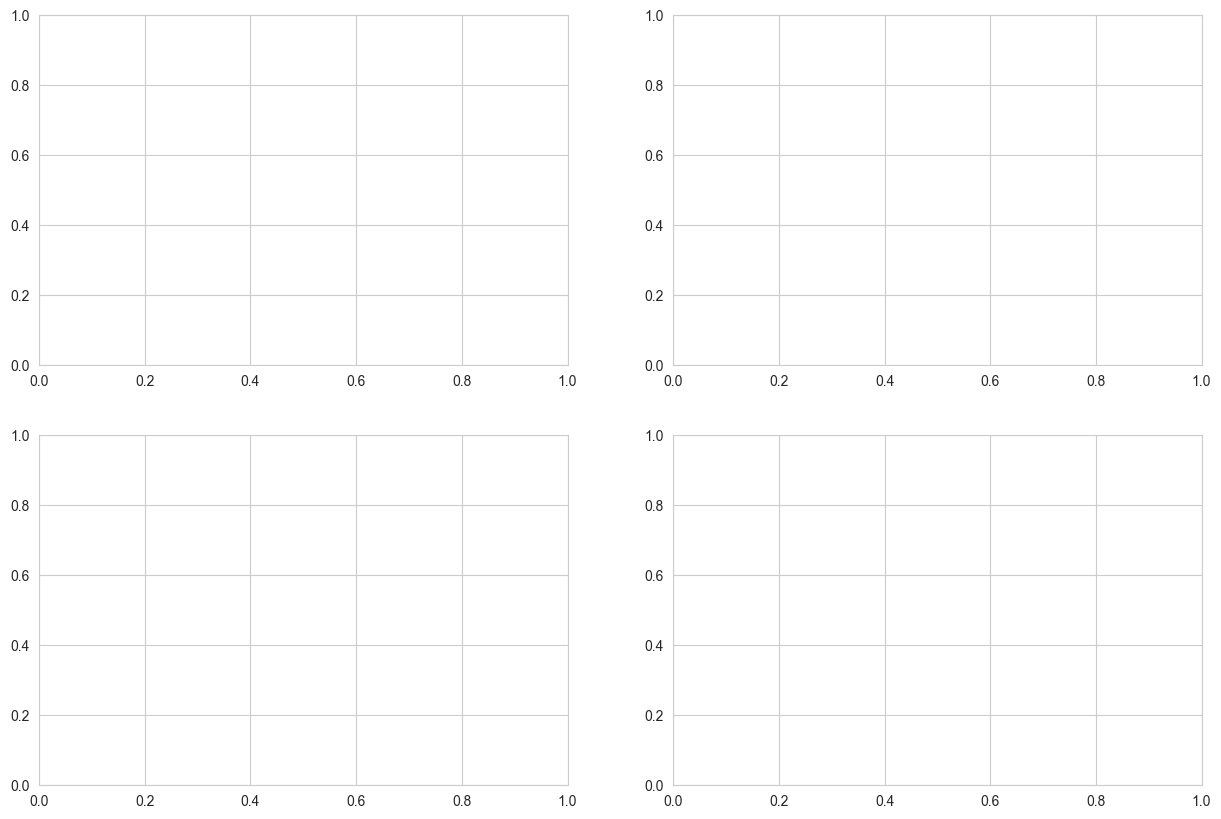

In [6]:
# 추가 변수 생성 (분석용)
df_analysis = df_final.copy()
df_analysis['Seq_Length'] = df_analysis['Sequence'].str.len()
df_analysis['Has_Leucine'] = df_analysis['Sequence'].str.contains('L').astype(int)
df_analysis['First_AA'] = df_analysis['Sequence'].str[0]
df_analysis['Last_AA'] = df_analysis['Sequence'].str[-1]
df_analysis['Hydrophobic_Count'] = df_analysis['Sequence'].apply(
    lambda x: sum(1 for aa in x if aa in 'AILMFPWV')
)

# 시각화 1: Label 분포
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

In [7]:
# 1-1. Label 분포
ax1 = axes[0, 0]
label_counts = df_final['Label'].value_counts()
colors = ['#2ecc71' if 'Positive' in str(idx) else '#e74c3c' for idx in label_counts.index]
ax1.bar(range(len(label_counts)), label_counts.values, color=colors, alpha=0.7)
ax1.set_xticks(range(len(label_counts)))
ax1.set_xticklabels(['Positive', 'Negative'], rotation=0)
ax1.set_ylabel('데이터 개수', fontsize=12)
ax1.set_title('1️⃣ 면역 반응 Label 분포', fontsize=14, fontweight='bold')
for i, v in enumerate(label_counts.values):
    ax1.text(i, v + 1000, f'{v:,}개\n({v/len(df_final)*100:.1f}%)', 
             ha='center', fontweight='bold')


ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of labels (2).

In [ ]:
# 1-2. 아미노산 히트맵
ax2 = axes[0, 1]
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
heatmap_data = np.zeros((20, 9))
for seq in df_final['Sequence'][:10000]:  # 샘플링으로 속도 향상
    for i, aa in enumerate(seq):
        if aa in amino_acids:
            heatmap_data[amino_acids.index(aa), i] += 1

sns.heatmap(heatmap_data, 
            xticklabels=range(1, 10), 
            yticklabels=list(amino_acids), 
            cmap='YlOrRd', 
            ax=ax2,
            cbar_kws={'label': '출현 빈도'})
ax2.set_title('2️⃣ 신항원 서열 위치별 아미노산 분포', fontsize=14, fontweight='bold')
ax2.set_xlabel('펩타이드 위치 (1~9번)')

c:\VSCode\python work\.venv\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from font(s) Arial.
  fig.canvas.draw()
c:\VSCode\python work\.venv\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE HYEON}) missing from font(s) Arial.
  fig.canvas.draw()
c:\VSCode\python work\.venv\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) Arial.
  fig.canvas.draw()
c:\VSCode\python work\.venv\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) Arial.
  fig.canvas.draw()


Text(0.5, 500.7222222222223, '펩타이드 위치 (1~9번)')

In [ ]:
# 1-3. 소수성 아미노산 분포
ax3 = axes[1, 0]
ax3.hist(df_analysis['Hydrophobic_Count'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)
ax3.set_xlabel('소수성 아미노산 개수', fontsize=12)
ax3.set_ylabel('빈도', fontsize=12)
ax3.set_title('3️⃣ 서열 내 소수성 아미노산 분포', fontsize=14, fontweight='bold')
ax3.axvline(df_analysis['Hydrophobic_Count'].mean(), 
            color='red', linestyle='--', linewidth=2, label='평균')
ax3.legend()

In [ ]:
# 1-4. 첫/마지막 아미노산 빈도
ax4 = axes[1, 1]
first_aa_counts = df_analysis['First_AA'].value_counts().head(10)
ax4.barh(range(len(first_aa_counts)), first_aa_counts.values, color='coral', alpha=0.7)
ax4.set_yticks(range(len(first_aa_counts)))
ax4.set_yticklabels(first_aa_counts.index)
ax4.set_xlabel('출현 빈도', fontsize=12)
ax4.set_title('4️⃣ 첫 번째 위치 아미노산 Top 10', fontsize=14, fontweight='bold')
ax4.invert_yaxis()

plt.tight_layout()
plt.savefig('eda_analysis.png', dpi=300, bbox_inches='tight')
print("✅ 시각화 저장: eda_analysis.png")
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\2000814488.py:11: UserWarning: Glyph 54185 (\N{HANGUL SYLLABLE PEB}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\2000814488.py:11: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\2000814488.py:11: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\2000814488.py:11: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\2000814488.py:11: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\2000814488.py:11: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\

✅ 시각화 저장: eda_analysis.png


C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\2000814488.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [ ]:
# [Cell 7] 데이터 전처리 (원핫 인코딩)
print("\n" + "="*70)
print("🔧 STEP 5: 데이터 전처리 (원핫 인코딩)")
print("="*70)

def neoantigen_onehot(sequences):
    """
    아미노산 서열을 딥러닝 모델 입력용 숫자 행렬로 변환
    - 입력: 문자열 리스트 ['KLLMVLMLA', ...]
    - 출력: numpy 배열 (샘플 수, 9, 20)
    """
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}
    
    encoded = []
    for seq in sequences:
        matrix = np.zeros((9, 20))
        for i, aa in enumerate(seq):
            if aa in aa_to_int:
                matrix[i, aa_to_int[aa]] = 1
        encoded.append(matrix)
    return np.array(encoded)

# X: 펩타이드 서열 (입력 데이터)
X = neoantigen_onehot(df_final['Sequence'].values)

# y: 면역 반응 여부 (정답 데이터)
y = (df_final['Label'].str.contains('Positive', case=False)).astype(int).values

print(f"✅ X (입력 데이터) shape: {X.shape}")
print(f"   - {X.shape[0]:,}개 샘플")
print(f"   - 각 샘플: 9개 위치 × 20종 아미노산")
print(f"\n✅ y (정답) shape: {y.shape}")
print(f"   - Positive: {y.sum():,}개 ({y.sum()/len(y)*100:.1f}%)")
print(f"   - Negative: {len(y)-y.sum():,}개 ({(len(y)-y.sum())/len(y)*100:.1f}%)")

# [Cell 8] 데이터 분할
print("\n" + "="*70)
print("✂️ STEP 6: 학습/테스트 데이터 분할 (80:20)")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ 학습 데이터: {len(X_train):,}개 ({len(X_train)/len(X)*100:.1f}%)")
print(f"✅ 테스트 데이터: {len(X_test):,}개 ({len(X_test)/len(X)*100:.1f}%)")
print(f"\n[클래스 균형 확인]")
print(f"학습 데이터 Positive 비율: {y_train.sum()/len(y_train)*100:.2f}%")
print(f"테스트 데이터 Positive 비율: {y_test.sum()/len(y_test)*100:.2f}%")

# [Cell 9] 1D-CNN 모델 구축
print("\n" + "="*70)
print("🤖 STEP 7: 딥러닝 모델 구축 (1D-CNN)")
print("="*70)


🔧 STEP 5: 데이터 전처리 (원핫 인코딩)
✅ X (입력 데이터) shape: (462017, 9, 20)
   - 462,017개 샘플
   - 각 샘플: 9개 위치 × 20종 아미노산

✅ y (정답) shape: (462017,)
   - Positive: 461,693개 (99.9%)
   - Negative: 324개 (0.1%)

✂️ STEP 6: 학습/테스트 데이터 분할 (80:20)
✅ 학습 데이터: 369,613개 (80.0%)
✅ 테스트 데이터: 92,404개 (20.0%)

[클래스 균형 확인]
학습 데이터 Positive 비율: 99.93%
테스트 데이터 Positive 비율: 99.93%

🤖 STEP 7: 딥러닝 모델 구축 (1D-CNN)


In [ ]:
model = models.Sequential([
    # Conv1D: 서열 내 패턴(모티프) 추출
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(9, 20)),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.2),
    
    # 추가 Conv Layer로 복잡한 패턴 학습
    layers.Conv1D(32, kernel_size=2, activation='relu'),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    
    # 출력: Positive일 확률 (0~1)
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

print(model.summary())

# [Cell 10] 모델 학습
print("\n" + "="*70)
print("🚀 STEP 8: 모델 학습 시작")
print("="*70)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

print("\n✅ 학습 완료!")

# [Cell 11] 학습 과정 시각화
print("\n" + "="*70)
print("📈 STEP 9: 학습 결과 시각화")
print("="*70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

c:\VSCode\python work\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 7, 64)          │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 32)          │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,305 (55.88 KB)

 Trainable params: 14,305 (55.88 KB)

 Non-trainable params: 0 (0.00 B)

None

🚀 STEP 8: 모델 학습 시작
Epoch 1/10
11551/11551 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.9990 - auc: 0.5528 - loss: 0.0076 - val_accuracy: 0.9993 - val_auc: 0.6584 - val_loss: 0.0052
Epoch 2/10
11551/11551 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.9993 - auc: 0.5885 - loss: 0.0062 - val_accuracy: 0.9993 - val_auc: 0.6137 - val_loss: 0.0049
Epoch 3/10
11551/11551 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.9993 - auc: 0.6251 - loss: 0.0058 - val_accuracy: 0.9993 - val_auc: 0.5996 - val_loss: 0.0063
Epoch 4/10
11551/11551 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.9993 - auc: 0.6671 - loss: 0.0057 - val_accuracy: 0.9993 - val_auc: 0.7430 - val_loss: 0.0049
Epoch 5/10
11551/11551 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.9993 - auc: 0.6929 - loss: 0.0052 - val_accuracy: 0.9993 - val_auc: 0.6828 - val_loss: 0.0051
Epoch 6/10
11551/11551 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.9993 - auc: 0.7092 - loss: 0.0051 - val_accuracy: 0.9993 - val_auc: 0.6949 - va

In [ ]:
# 1. Accuracy
ax1 = axes[0]
ax1.plot(history.history['accuracy'], label='학습 정확도', linewidth=2, marker='o')
ax1.plot(history.history['val_accuracy'], label='검증 정확도', linewidth=2, marker='s')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('1️⃣ 모델 정확도 (Accuracy)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
final_acc = history.history['val_accuracy'][-1]
ax1.text(9, final_acc, f'{final_acc*100:.2f}%', 
         fontsize=12, fontweight='bold', color='red')

# 2. Loss
ax2 = axes[1]
ax2.plot(history.history['loss'], label='학습 손실', linewidth=2, marker='o')
ax2.plot(history.history['val_loss'], label='검증 손실', linewidth=2, marker='s')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('2️⃣ 모델 손실 (Loss)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# 3. AUC
ax3 = axes[2]
ax3.plot(history.history['auc'], label='학습 AUC', linewidth=2, marker='o')
ax3.plot(history.history['val_auc'], label='검증 AUC', linewidth=2, marker='s')
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('AUC', fontsize=12)
ax3.set_title('3️⃣ AUC Score', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)
final_auc = history.history['val_auc'][-1]
ax3.text(9, final_auc, f'{final_auc:.4f}', 
         fontsize=12, fontweight='bold', color='red')

plt.tight_layout()
plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
print("✅ 시각화 저장: training_results.png")
plt.show()

# [Cell 12] 모델 평가
print("\n" + "="*70)
print("🎯 STEP 10: 최종 모델 성능 평가")
print("="*70)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\3903593425.py:37: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\3903593425.py:37: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\3903593425.py:37: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\3903593425.py:37: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\3903593425.py:37: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\3903593425.py:37: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) Arial.
  plt.tight_lay

✅ 시각화 저장: training_results.png

🎯 STEP 10: 최종 모델 성능 평가


C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\3903593425.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [ ]:
# 테스트 데이터로 평가
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)

print(f"""
╔════════════════════════════════════════════╗
║         최종 모델 성능 지표                 ║
╠════════════════════════════════════════════╣
║  정확도 (Accuracy):  {test_acc*100:>6.2f}%          ║
║  AUC Score:          {test_auc:>6.4f}            ║
║  손실 (Loss):        {test_loss:>6.4f}            ║
╚════════════════════════════════════════════╝
""")



╔════════════════════════════════════════════╗
║         최종 모델 성능 지표                 ║
╠════════════════════════════════════════════╣
║  정확도 (Accuracy):   99.93%          ║
║  AUC Score:          0.6383            ║
║  손실 (Loss):        0.0064            ║
╚════════════════════════════════════════════╝



In [ ]:
# Confusion Matrix
y_pred = (model.predict(X_test, verbose=0) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix 시각화
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            annot_kws={'size': 14, 'weight': 'bold'})
ax1.set_xlabel('예측값', fontsize=12, fontweight='bold')
ax1.set_ylabel('실제값', fontsize=12, fontweight='bold')
ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

# ROC Curve
ax2 = axes[1]
y_pred_proba = model.predict(X_test, verbose=0)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

ax2.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.50)')
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('evaluation_results.png', dpi=300, bbox_inches='tight')
print("✅ 시각화 저장: evaluation_results.png")
plt.show()

# Classification Report
print("\n[상세 분류 리포트]")
print(classification_report(y_test, y_pred, 
                           target_names=['Negative', 'Positive'],
                           digits=4))

# [Cell 13] 모델 저장
print("\n" + "="*70)
print("💾 STEP 11: 모델 저장")
print("="*70)

model.save("lung_cancer_model.keras")
print("✅ 모델이 'lung_cancer_model.keras'로 저장되었습니다!")
print("   → Streamlit 앱에서 이 파일을 불러와 실시간 예측에 사용합니다.")

# [Cell 14] 샘플 예측 데모
print("\n" + "="*70)
print("🔬 STEP 12: 신항원 예측 데모 (샘플 5개)")
print("="*70)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\821679929.py:31: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\821679929.py:31: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\821679929.py:31: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\821679929.py:31: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\821679929.py:31: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\821679929.py:32: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) Arial.
  plt.savefig('evaluation_resul

✅ 시각화 저장: evaluation_results.png

[상세 분류 리포트]
              precision    recall  f1-score   support

    Negative     1.0000    0.0154    0.0303        65
    Positive     0.9993    1.0000    0.9997     92339

    accuracy                         0.9993     92404
   macro avg     0.9997    0.5077    0.5150     92404
weighted avg     0.9993    0.9993    0.9990     92404


💾 STEP 11: 모델 저장
✅ 모델이 'lung_cancer_model.keras'로 저장되었습니다!
   → Streamlit 앱에서 이 파일을 불러와 실시간 예측에 사용합니다.

🔬 STEP 12: 신항원 예측 데모 (샘플 5개)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\821679929.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [ ]:
# Confusion Matrix
y_pred = (model.predict(X_test, verbose=0) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix 시각화
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            annot_kws={'size': 14, 'weight': 'bold'})
ax1.set_xlabel('예측값', fontsize=12, fontweight='bold')
ax1.set_ylabel('실제값', fontsize=12, fontweight='bold')
ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

# ROC Curve
ax2 = axes[1]
y_pred_proba = model.predict(X_test, verbose=0)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

ax2.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.50)')
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('evaluation_results.png', dpi=300, bbox_inches='tight')
print("✅ 시각화 저장: evaluation_results.png")
plt.show()

# Classification Report
print("\n[상세 분류 리포트]")
print(classification_report(y_test, y_pred, 
                           target_names=['Negative', 'Positive'],
                           digits=4))

# [Cell 13] 모델 저장
print("\n" + "="*70)
print("💾 STEP 11: 모델 저장")
print("="*70)

model.save("lung_cancer_model.keras")
print("✅ 모델이 'lung_cancer_model.keras'로 저장되었습니다!")
print("   → Streamlit 앱에서 이 파일을 불러와 실시간 예측에 사용합니다.")

# [Cell 14] 샘플 예측 데모
print("\n" + "="*70)
print("🔬 STEP 12: 신항원 예측 데모 (샘플 5개)")
print("="*70)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\821679929.py:31: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\821679929.py:31: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\821679929.py:31: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\821679929.py:31: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\821679929.py:31: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\821679929.py:32: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) Arial.
  plt.savefig('evaluation_resul

✅ 시각화 저장: evaluation_results.png

[상세 분류 리포트]
              precision    recall  f1-score   support

    Negative     1.0000    0.0154    0.0303        65
    Positive     0.9993    1.0000    0.9997     92339

    accuracy                         0.9993     92404
   macro avg     0.9997    0.5077    0.5150     92404
weighted avg     0.9993    0.9993    0.9990     92404


💾 STEP 11: 모델 저장
✅ 모델이 'lung_cancer_model.keras'로 저장되었습니다!
   → Streamlit 앱에서 이 파일을 불러와 실시간 예측에 사용합니다.

🔬 STEP 12: 신항원 예측 데모 (샘플 5개)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_4012\821679929.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
